**Sentiment analysis using LSTM**

In [1]:
# Importing required libraries
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import Word
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt                                                                                                                                  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading the dataset
data = pd.read_csv('amazon_alexa.tsv',sep='\t')

# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'

data['sentiment'] = data.apply(sentiments, axis=1)    


In [4]:
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'

data['sentiment'] = data.apply(sentiments, axis=1)    


In [30]:
# Considering two features for performing sentiment analysis
data_v1 = data[['verified_reviews','sentiment']]
data_v1.head()

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive


In [31]:
#Separating positive and negative review
data_neg=data_v1[data_v1['sentiment']=='Negative']
data_pos=data_v1[data_v1['sentiment']=='Positive']

In [32]:
#Picking only top 1000 positive review to overcome imbalances
data_pos_filtered = data_pos.head(1000)

In [33]:
result = pd.concat([data_pos_filtered,data_neg])

In [34]:
result.shape

(1409, 2)

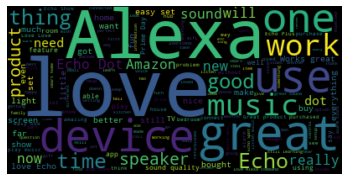

In [6]:
#Word cloud
common_words=''
for i in result.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#Check if there are any null values
data_v1 = result[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [36]:
#Checking class balance
Counter(data_v1['sentiment'])

Counter({'Negative': 409, 'Positive': 1000})

In [37]:
# Data cleaning / preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
#Logic to remove uncessary noises from the reviews

def cleaning(df, stop_words):
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #Replacing the special characters
    df['verified_reviews'] = df['verified_reviews'].str.replace('[^\w\s]', '')
    #Replacing the digits/numbers 
    df['verified_reviews'] = df['verified_reviews'].str.replace('\d', '') 
    #Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    #Lemmatization 
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join([Word(x).lemmatize() for x in x.split()])) 
    return df


stop_words = stopwords.words('english')
data_v1=cleaning(data_v1, stop_words)



In [39]:
data_v1.head()

,verified_reviews,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing yr old learns dinosaur control l...,Positive
4,music,Positive


In [41]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])





In [42]:
data_v1.shape   

(1409, 2)

In [43]:
#Maximum number of words to keep based on word frequency , Separator for word splitting
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data_v1['verified_reviews'].values)
X = pad_sequences(X)

In [56]:
#Saving the tokenizer as pickle file
import pickle
filename = 'tokenizer4.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

In [44]:
X.shape[1]

112

In [45]:
#Model initialization
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())                                                                                  
                                                                                                                                         

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 112, 120)          60000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 112, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 176)               209088    
                                                                 
 dense_1 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 42)

In [47]:
#Model training
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
31/31 [==============================] - 15s 420ms/step - loss: 0.5904 - accuracy: 0.7039
Epoch 2/5
31/31 [==============================] - 13s 410ms/step - loss: 0.5117 - accuracy: 0.7343
Epoch 3/5
31/31 [==============================] - 13s 416ms/step - loss: 0.3513 - accuracy: 0.8509
Epoch 4/5
31/31 [==============================] - 13s 410ms/step - loss: 0.2405 - accuracy: 0.8905
Epoch 5/5
31/31 [==============================] - 13s 416ms/step - loss: 0.2292 - accuracy: 0.9118


In [48]:
#Model evaluation
model.evaluate(X_test,y_test)

14/14 [==============================] - 1s 53ms/step - loss: 0.4598 - accuracy: 0.8109


[0.4597603976726532, 0.8108747005462646]

In [49]:
#Saving the model
model.save('finalmodel6')  

INFO:tensorflow:Assets written to: finalmodel6/assets


In [55]:
#Zipping the saved model folder
!zip -r /content/file.zip /content/finalmodel6

  adding: content/finalmodel6/ (stored 0%)
  adding: content/finalmodel6/keras_metadata.pb (deflated 87%)
  adding: content/finalmodel6/saved_model.pb (deflated 89%)
  adding: content/finalmodel6/variables/ (stored 0%)
  adding: content/finalmodel6/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/finalmodel6/variables/variables.index (deflated 60%)
  adding: content/finalmodel6/assets/ (stored 0%)


In [50]:
#Predicting the test data
y_pred = model.predict(X_test)


In [241]:
y_pred

array([[4.9655355e-05, 9.9995029e-01],
       [6.7865248e-03, 9.9321353e-01],
       [1.8917178e-01, 8.1082821e-01],
       ...,
       [1.4504002e-02, 9.8549598e-01],
       [2.5937126e-03, 9.9740630e-01],
       [6.8764105e-02, 9.3123585e-01]], dtype=float32)

In [57]:
y_pred1=[]
for i in y_pred:
  if i[0]>i[1]:
    y_pred1.append(0)
  else:
    y_pred1.append(1)


In [58]:
ytest1=[]
for i in y_test.tolist():
  ytest1.append(i[1])

In [59]:
print(classification_report(ytest1,y_pred1))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62       123
           1       0.83      0.93      0.87       300

    accuracy                           0.81       423
   macro avg       0.79      0.73      0.75       423
weighted avg       0.80      0.81      0.80       423



In [53]:
X2 = tokenizer.texts_to_sequences(["poor product poor performance"])
X2 = pad_sequences(X2, maxlen=112, dtype='int32', value=0)

In [54]:
y_pred2 = model.predict(X2) 
print(y_pred2)

[[0.7037456  0.29625443]]
